In [1]:
import os, warnings, sys, yaml
from stream2segment.process.db import get_session
from stream2segment.io.db.models import Station, Segment, concat, Channel
from stream2segment.io.utils import loads_inv
# warnings.simplefilter('always')
_fle = os.path.abspath(os.path.join('.', 'jnconfig.yaml'))
assert os.path.isfile(_fle)
with open(_fle, "r") as _:
    jnconfig = yaml.safe_load(_)

dbpath_old = jnconfig['dbpath_old']
dbpath_new = jnconfig['dbpath_new']

In [2]:
def station_key(station):
    return station.network + '.' + station.station + '.' + station.start_time.isoformat()

def printred(string):
    print("\x1b[31m%s\x1b[0m" % string)

In [9]:
from stream2segment.process.math.traces import ampratio, bandpass, cumsumsq,\
    timeswhere, fft, maxabs, utcdatetime, ampspec, powspec, timeof

preprocess_config = {
  'remove_response_water_level': 60,
  'remove_response_output': 'ACC',
  'bandpass_freq_max': 30,  # the max frequency, in Hz:
  'bandpass_max_nyquist_ratio': 0.9,
  'bandpass_corners': 2
}
def bandpass_remresp(segment, inventory=None):
    """Applies a pre-process on the given segment waveform by
    filtering the signal and removing the instrumental response.
    DOES modify the segment stream in-place (see below)

    The filter algorithm has the following steps:
    1. Sets the max frequency to 0.9 of the Nyquist frequency (sampling rate /2)
    (slightly less than Nyquist seems to avoid artifacts)
    2. Offset removal (subtract the mean from the signal)
    3. Tapering
    . Pad data with zeros at the END in order to accommodate the filter transient
nf['bandpass_freq_max']
    5. Apply bandpass filter, where the lower frequency is set according to the magnitude
    6. Remove padded elements
    7. Remove the instrumental response

    IMPORTANT NOTES:
    - Being decorated with '@gui.preprocess', this function:
      * returns the *base* stream used by all plots whenever the relative check-box is on
      * must return either a Trace or Stream object

    - In this implementation THIS FUNCTION DOES MODIFY `segment.stream()` IN-PLACE: from within
      `main`, further calls to `segment.stream()` will return the stream returned by this function.
      However, In any case, you can use `segment.stream().copy()` before this call to keep the
      old "raw" stream

    :return: a Trace object.
    """
    stream = segment.stream().copy()
    trace = stream[0]

    if inventory is None:
        inventory = segment.inventory()

    # define some parameters:
    evt = segment.event
    conf = preprocess_config
    # note: bandpass here below copied the trace! important!
    trace = bandpass(trace, mag2freq(evt.magnitude), freq_max=conf['bandpass_freq_max'],
                     max_nyquist_ratio=conf['bandpass_max_nyquist_ratio'],
                     corners=conf['bandpass_corners'], copy=False)
    trace.remove_response(inventory=inventory, output=conf['remove_response_output'],
                          water_level=conf['remove_response_water_level'])
    return trace

def mag2freq(magnitude):
    if magnitude <= 4.:
        freq_min = 0.5
    elif magnitude <= 5.0:
        freq_min = 0.4
    elif magnitude <= 6.0:
        freq_min = 0.2
    elif magnitude <= 6.5:
        freq_min = 0.1
    else:
        freq_min = 0.05
    return freq_min


In [10]:
from sqlalchemy import func

# STATION = 'CH.GRIMS'
# STATION = 'FR.PYLO'
# STATION = 'SK.MODS'
# STATION = 'SK.ZST'

# NOT WORKING (not in both databses, or no channels etc):
# SK_SRO_EH, SL_KNDS_HH, SL_JAVS_HH IV_SGG_HN
# CQ_PARA_HH CQ_ATHA_HH CQ_TROD_HH CQ_NATA_HH CQ_SUNI_HH CQ_MVOU_HH CQ_ASGA_HH CQ_ALEF_HH CQ_AKMS_HH


#   " "" "" "" "
    
STATION = 'SK.MODS'

# instantiate a dict of stations ids -> [Station old, Station new]
stations = {}
net_, sta_ = STATION.split('.')

print('CHECKING STATIONS (might take a while): old dbase')
sess = get_session(dbpath_old)
try:
    for sta in sess.query(Station).filter((Station.network == net_) & (Station.station == sta_)):
        stations[station_key(sta)] = [sta, None, set(cha.channel for cha in sta.channels)]
finally:
    sess.close()

print('CHECKING STATIONS (might take a while): new dbase')
sess = get_session(dbpath_new)
try:
    for sta in sess.query(Station).filter((Station.network == net_) & (Station.station == sta_)):
        stakey = station_key(sta)
        if stakey not in stations:  # no segments with data in the other database
            print('not found in old database: %s' % stakey)
            continue
        newchannels = set(cha.channel for cha in sta.channels)
        stations[stakey][1] = sta
        stations[stakey][2] &= newchannels
finally:
    sess.close()

for k, v in list(stations.items()):
    if v[0] is None or v[1] is None:
        print('not found in old database: %s' % k)
        stations.pop(k)
    elif not v[2]:
        print('no shared channels between databases: %s' % k)
        stations.pop(k)

print("")
if not stations:
    printred("No stations found")
    # raise Exception('No stations found')
else:
    print('Stations found:')
    for sta in stations:
        print(sta)

CHECKING STATIONS (might take a while): old dbase
CHECKING STATIONS (might take a while): new dbase
not found in old database: SK.MODS.2011-11-15T00:00:00

Stations found:
SK.MODS.2004-03-17T00:00:00


In [11]:
from sqlalchemy import create_engine
channels2traces = {}
sess = get_session(dbpath_new)
try:
    for sta_key, (sta_old, sta_new, channels) in stations.items():
        for cha in channels:
            seg = sess.query(Segment).join(Segment.station, Segment.channel).\
                filter((Segment.has_data == True) & (Station.id == sta_new.id) & (Channel.channel == cha)).first()
#             if not seg:
#                 eng = create_engine(dbpath_old)
#                 with eng.connect() as con:
#                     raw_sql = ('select segments.data from segments '
#                                'JOIN channels on segments.channel_id = channels.id '
#                                'JOIN stations on stations.id = channels.station_id '
#                                'WHERE stations.id = %d AND channels.channel = \'%s\' '
#                                'AND segments.data IS NOT NULL '
#                                'AND length(segments.data) > 0 limit 1') % (sta_old.id, cha)
#                     data = con.execute(raw_sql).fetchone()
#                     print(data)

            chakey = sta_key + ' (channel: ' + cha + ")"
            if seg:
                assert seg.channel.channel == cha
                try:
                    trace1, trace2 = bandpass_remresp(seg, sta_old.inventory()), bandpass_remresp(seg, sta_new.inventory()) 
                    channels2traces[chakey] = trace1, trace2
                    print('Done %s' % chakey)
                except Exception as exc:
                    print('Error with %s: %s' % (chakey, str(exc)))
            else:
                print('Error with %s: No segment with data found' % chakey)
finally:
    sess.close()

if len(channels2traces):
    print("%d channels found" % len(channels2traces))
else:
    printred("%d channels found" % len(channels2traces))

Done SK.MODS.2004-03-17T00:00:00 (channel: EHE)
Done SK.MODS.2004-03-17T00:00:00 (channel: EHN)
Done SK.MODS.2004-03-17T00:00:00 (channel: EHZ)
Done SK.MODS.2004-03-17T00:00:00 (channel: HHE)
Done SK.MODS.2004-03-17T00:00:00 (channel: HHN)
Done SK.MODS.2004-03-17T00:00:00 (channel: HHZ)
6 channels found


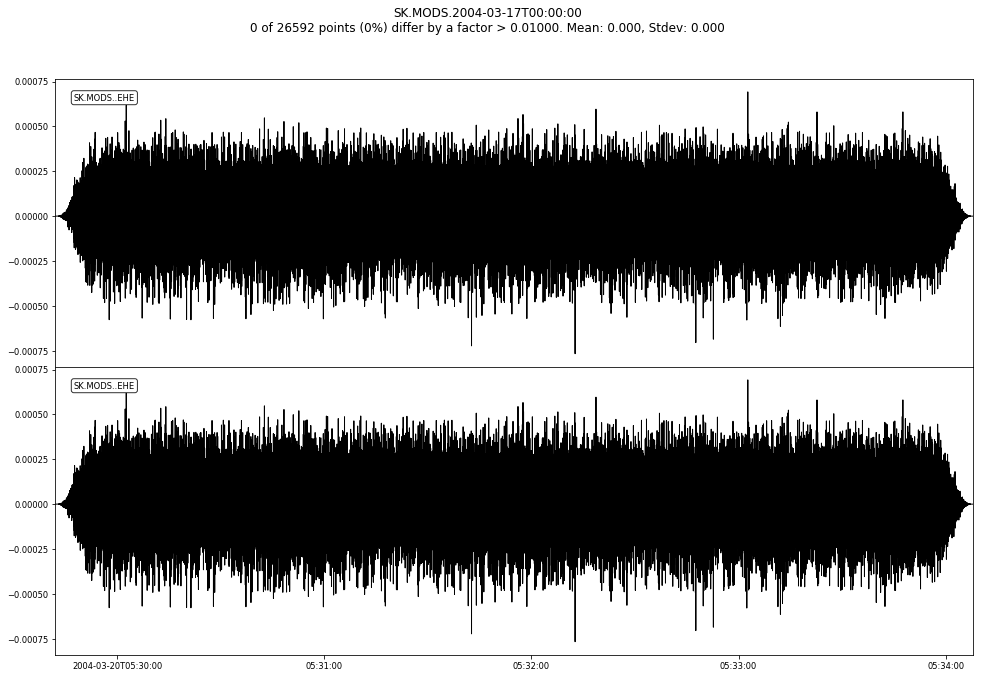

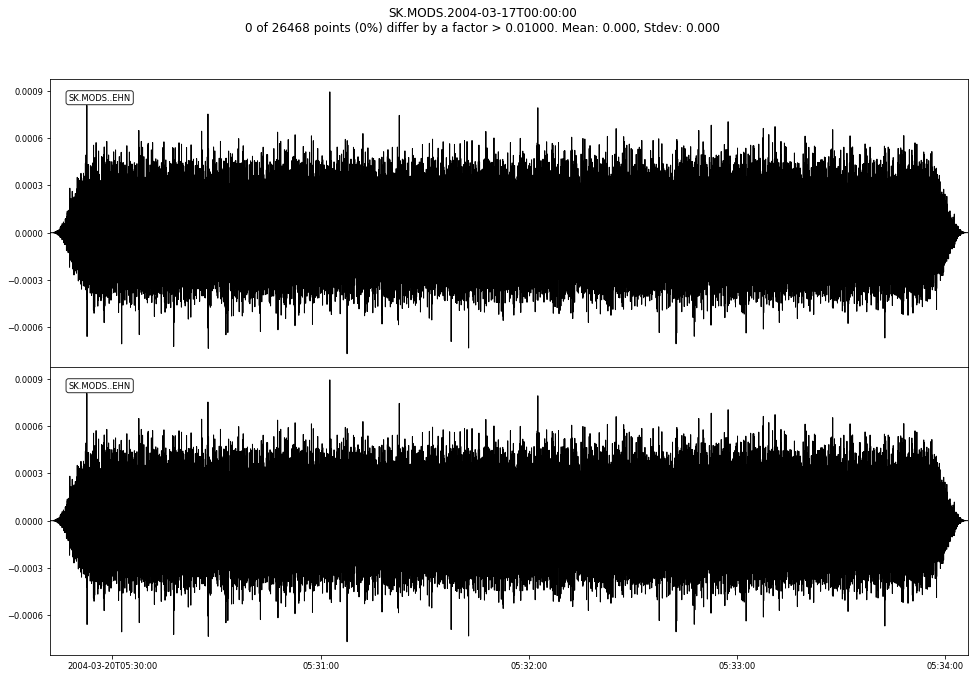

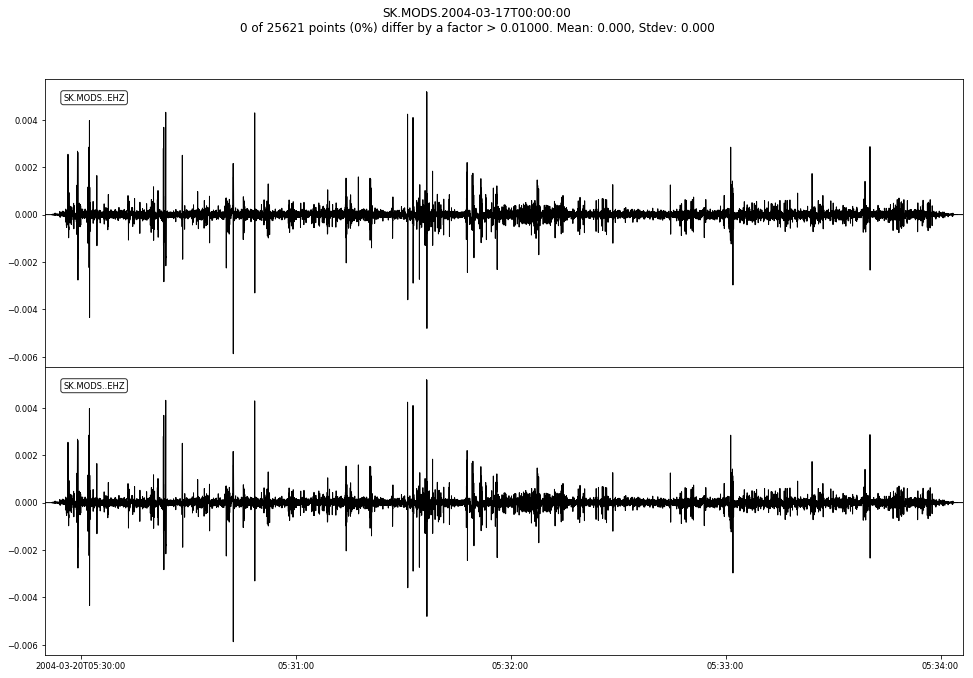

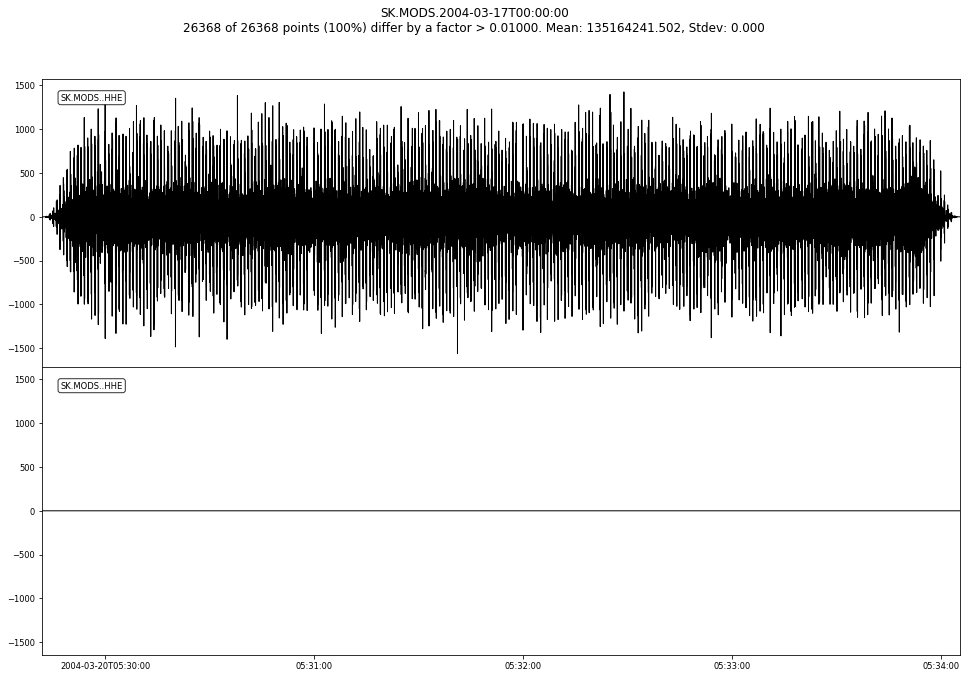

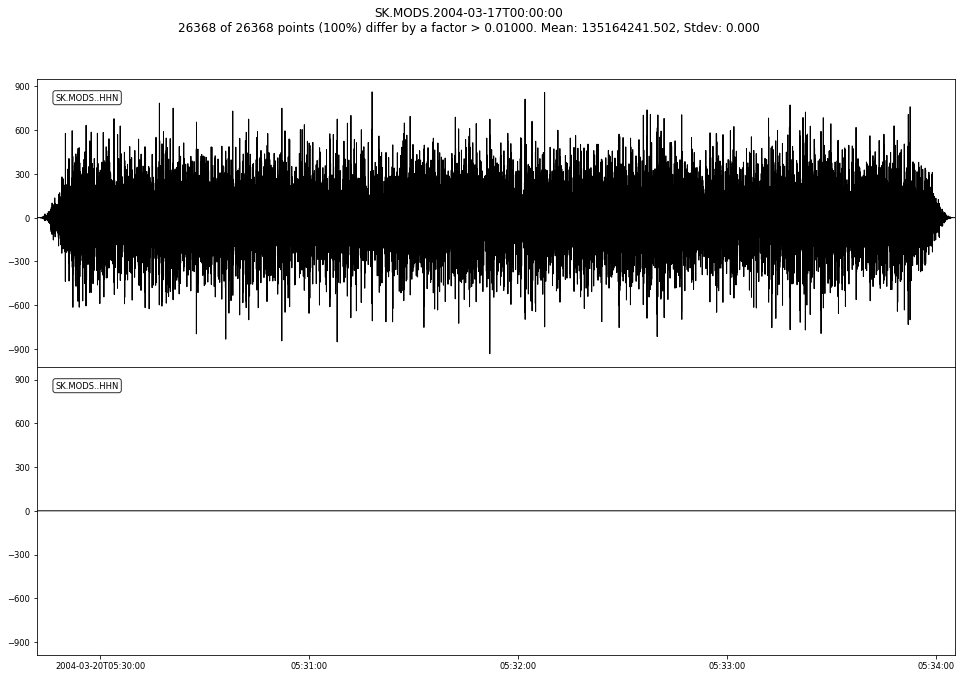

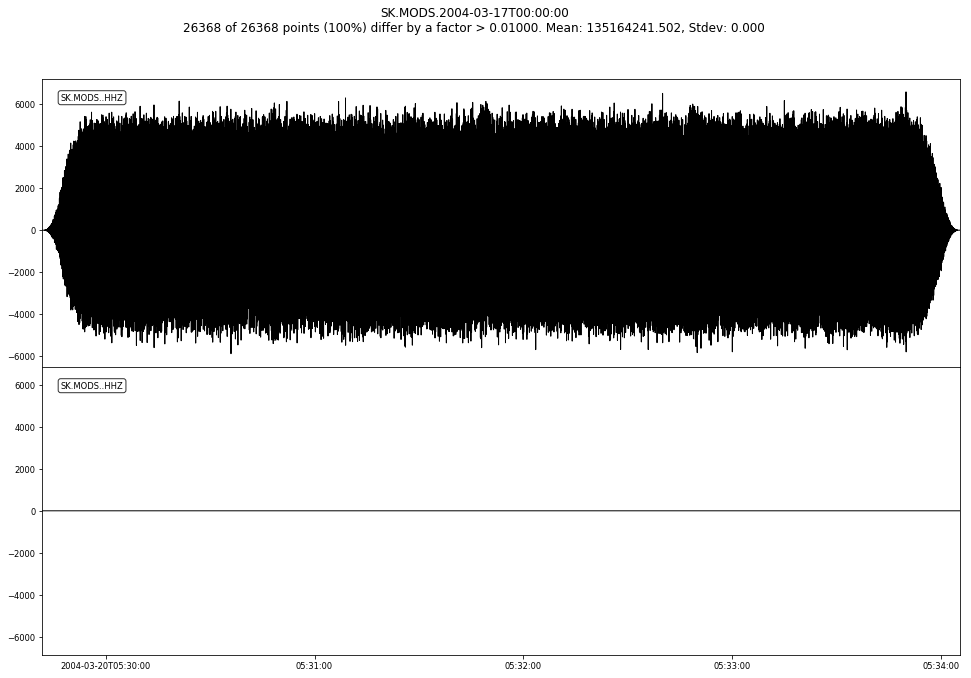

Suspiciously wrong stations between the two databases:
SK.MODS.2004-03-17T00:00:00.EHE
SK.MODS.2004-03-17T00:00:00.EHN
SK.MODS.2004-03-17T00:00:00.EHZ
SK.MODS.2004-03-17T00:00:00.HHE
SK.MODS.2004-03-17T00:00:00.HHN
SK.MODS.2004-03-17T00:00:00.HHZ
6 found


In [12]:
# let's try with one and plot it, you will see they are identical just SCALED:
from obspy import Trace, Stream, UTCDateTime
import numpy as np
import re

alltraces = []

for traces in channels2traces.values():
    alltraces.extend(traces)

import matplotlib.pyplot as plt
%matplotlib inline

suspicious = set()
rtol = 0.01
for key, traces in channels2traces.items():
    fig = plt.figure(figsize=(15, 10))
    sta_key = key.split(' (channel: ')[0]
    figtitle = sta_key
    rdiffs = np.abs((traces[0].data - traces[1].data) / traces[1].data)
    numerrors = (rdiffs > rtol).sum()
    mean, std = np.nanmean(rdiffs), np.nanstd(rdiffs)
    # create a color just for warning purposes:
    # the more error mean, the more red (weight:2/3), the less stdev, the more red (weight: 1/3)
    color = 'k'  # [.67 * mean + .33 * (1 - std), 0, 0]
    suspicious.add(key)
    figtitle += '\n%d of %d points (%d%%) differ by a factor > %.5f. Mean: %.3f, Stdev: %.3f' % \
        (numerrors, len(rdiffs), int(100.0*numerrors/len(rdiffs)), rtol, mean, std)
    Stream(traces).plot(fig=fig, color=color)
    fig.suptitle(figtitle, color=color)
    plt.show()
    


print('Suspiciously wrong stations between the two databases:')
for _ in sorted(suspicious):
    print(_.replace(' (channel: ', '.').replace(')', ''))
print('%d found' % len(suspicious))

In [ ]:
stations_list = '''
CH.GRIMS.2011-11-09T00:00:00.HHE
CH.GRIMS.2011-11-09T00:00:00.HHN
CH.GRIMS.2011-11-09T00:00:00.HHZ
CH.GRIMS.2015-10-30T10:50:00.HHE
CH.GRIMS.2015-10-30T10:50:00.HHN
CH.GRIMS.2015-10-30T10:50:00.HHZ
SK.MODS.2004-03-17T00:00:00.HHE
SK.MODS.2004-03-17T00:00:00.HHN
SK.MODS.2004-03-17T00:00:00.HHZ
SK.ZST.2004-03-17T00:00:00.HHE
SK.ZST.2004-03-17T00:00:00.HHN
SK.ZST.2004-03-17T00:00:00.HHZ
FR.PYLO.2010-01-17T10:00:00.HNE
FR.PYLO.2010-01-17T10:00:00.HNN
FR.PYLO.2010-01-17T10:00:00.HNZ
'''